In [113]:
import torch
from torchtext.vocab import Vocab
from torchtext import data, datasets
from konlpy.tag import Mecab
import re
import pandas as pd

mecab = Mecab()

import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence
from torch.nn.utils.rnn import pad_packed_sequence as unpack
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.autograd import Variable

# 1. 데이터 로드 및 전처리

In [70]:
train_file_path = './data/chat.in'
#train_file_path = './data/train_db.tsv'

In [71]:
#load dataset

delimiter = "\t"

def read_in_data(data_path):
    user = []
    bot = []
    with open(data_path, mode="rt", encoding="utf-8") as fh:
        utt = fh.readlines()
        
        for i, line in enumerate(utt):
            split_line = line.split(delimiter)
            query = split_line[0].replace("\"", "").replace("\n", "")
            answer = split_line[1].replace("\"", "").replace("\n", "")
            
            user.append(query)
            bot.append(answer)
            
        return user, bot
    
user_query, answer_query = read_in_data(train_file_path)

# #Just for test
user_query = user_query[:100]
answer_query = answer_query[:100]

# #Pandas Convert
# dict_data = {'user': user_query, 'bot': answer_query}
# df_data = pd.DataFrame(dict_data, columns=['user', 'bot'])
# df_data.to_csv(train_file_path, sep='\t')

# #Reading file
# df = pd.read_csv(train_file_path, delimiter='\t', keep_default_na=False)

In [72]:
#For preprocessing and morph.

# hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
hangul = re.compile('[^ ㅋㅎ가-힣]+')
def clean(sentence):
    clean_sentence = hangul.sub('', sentence)
    return clean_sentence

def mecab_tokenizer(sentence):
    out_list = []
    for word, pos in mecab.pos(sentence):
        out_list.append(word)
    return out_list

def tokenizer(sentence):
    clean_sentence = clean(sentence)
    tokens = mecab_tokenizer(clean_sentence)
    return tokens

QA_list = list(zip(user_query, answer_query)) # 튜플 형태의 데이터

In [76]:
# Separate vocab between question & answer (common in machine translation)
# question_field = data.Field(tokenize=tokenizer)
# answer_field = data.Field(tokenize=tokenizer)

# shared vocab between question & answer
text_field = data.Field(
    sequential=True,
    init_token='<시작>', # <sos>
    eos_token='<끝>', # <eos>
    pad_token='<패딩>', # <pad>
    tokenize=tokenizer,
    use_vocab=True,
    include_lengths=True,
    batch_first=True)

In [92]:
examples = []
for q, a in QA_list:
    example = data.Example.fromlist(
        data=[q, a],
        fields=[('question', text_field),
                ('answer', text_field)])
    examples.append(example)

from pprint import pprint

for ex in examples:
    pprint(vars(ex), compact=True, width=50)

{'answer': ['블로그', '는', '나', '만', '의', '경험', '과',
            '지식', '을', '포스팅', '으로', '작성', '하',
            '고', '동일', '한', '관심사', '를', '가진',
            '이용자', '와', '편리', '하', '게', '소통', '할',
            '수', '있', '는', '서비스', '입니다', '사진',
            '동영상', '지도', '파일', '등', '을', '첨부',
            '하', '여', '포스트', '를', '작성', '할', '수',
            '있', '으며', '이웃', '서로', '이웃', '과', '의',
            '교유', '등', '다양', '한', '소통', '기능', '을',
            '제공', '하', '고', '있', '습니다', '경험', '과',
            '정보', '의', '공유', '그리고', '소통', '이',
            '가능', '한', '블로그', '를', '지금', '시작',
            '해', '보', '세요'],
 'question': ['블로그', '가', '뭐', '야']}
{'answer': ['블로그', '는', '나', '만', '의', '경험', '과',
            '지식', '을', '포스팅', '으로', '작성', '하',
            '고', '동일', '한', '관심사', '를', '가진',
            '이용자', '와', '편리', '하', '게', '소통', '할',
            '수', '있', '는', '서비스', '입니다', '사진',
            '동영상', '지도', '파일', '등', '을', '첨부',
            '하', '여', '포스트', '를', '작성', '할', '수',
           

            '동영상', '지도', '파일', '등', '을', '첨부',
            '하', '여', '포스트', '를', '작성', '할', '수',
            '있', '으며', '이웃', '서로', '이웃', '과', '의',
            '교유', '등', '다양', '한', '소통', '기능', '을',
            '제공', '하', '고', '있', '습니다', '경험', '과',
            '정보', '의', '공유', '그리고', '소통', '이',
            '가능', '한', '블로그', '를', '지금', '시작',
            '해', '보', '세요'],
 'question': ['블로그', '의', '장점']}
{'answer': ['블로그', '는', '나', '만', '의', '경험', '과',
            '지식', '을', '포스팅', '으로', '작성', '하',
            '고', '동일', '한', '관심사', '를', '가진',
            '이용자', '와', '편리', '하', '게', '소통', '할',
            '수', '있', '는', '서비스', '입니다', '사진',
            '동영상', '지도', '파일', '등', '을', '첨부',
            '하', '여', '포스트', '를', '작성', '할', '수',
            '있', '으며', '이웃', '서로', '이웃', '과', '의',
            '교유', '등', '다양', '한', '소통', '기능', '을',
            '제공', '하', '고', '있', '습니다', '경험', '과',
            '정보', '의', '공유', '그리고', '소통', '이',
            '가능', '한', '블로그', '를', '지금', '시작',
         

            '때', '반복', '하', '여', '소개', '될', '수',
            '있', '습니다', '블로그', '에', '는', '너무',
            '다양', '한', '생각', '과', '콘텐츠', '가',
            '존재', '하', '기', '때문', '에', '보다', '다양',
            '하', '고', '많', '은', '블로거', '가', '소개',
            '될', '수', '있', '도록', '노력', '하', '고',
            '있', '습니다'],
 'question': ['이달', '의', '블로그', '중복', '선정']}
{'answer': ['주제', '에', '맞', '게', '좋', '은', '글',
            '을', '작성', '하', '는', '블로그', '라면',
            '해당', '하', '는', '주제', '가', '소개', '될',
            '때', '반복', '하', '여', '소개', '될', '수',
            '있', '습니다', '블로그', '에', '는', '너무',
            '다양', '한', '생각', '과', '콘텐츠', '가',
            '존재', '하', '기', '때문', '에', '보다', '다양',
            '하', '고', '많', '은', '블로거', '가', '소개',
            '될', '수', '있', '도록', '노력', '하', '고',
            '있', '습니다'],
 'question': ['이달', '의', '블로그', '중복', '선정', '이',
              '가능', '해']}
{'answer': ['주제', '에', '맞', '게', '좋', '은', '글',
            '을', '작성', '하', '는', '블로그', '라면',
        

In [83]:
def filter_pred(example):
    if len(example.question) > 2 and len(example.answer) > 2:
        return True
    return False

QA_dataset = data.Dataset(
    examples=examples,
#     sort_key=lambda x: len(x.question),
    fields=[
        ('question', text_field),
        ('answer', text_field)
    ],
    filter_pred=filter_pred
)

In [135]:
QA_dataset

In [86]:
#Build Vocab

text_field.build_vocab(QA_dataset)
vocab = text_field.vocab
len(vocab)

#vocab.freqs
#vocab.itos[0] #0: unk 1: 패딩 2: 시작 3: 끝
#vocab.stoi['어디']

276

In [149]:
#빈도수별로 짜르고 싶을때는..
frequent_vocab = Vocab(counter=vocab.freqs, min_freq=5)
len(frequent_vocab)

195

In [89]:
### utility fucntion for idx <-> token
# list of ids => list of tokens

def ids2token(ids):
    return [vocab.itos[id] for id in ids]

In [150]:
train_iter = data.Iterator(
    dataset=QA_dataset,
    batch_size=10,
    sort_key=lambda x: len(x.text),
    train=True, # if training set => repeat and shuffle : True 
    device=-1 # CPU: -1
)

# test_iter = data.Iterator(
#     dataset=naver_test,
#     batch_size=10,
#     sort=False,
#     train=False,
#     device=-1)

In [156]:
vars(next(iter(train_iter)))
a = next(iter(train_iter))
vars(a)
a.text

AttributeError: 'Batch' object has no attribute 'text'

## BucketIterator
- Defines an iterator that batches examples of similar lengths together.
    Minimizes amount of padding needed while producing freshly shuffled
    batches for each new epoch.
    
    -> RNN계열에서 활용도가 좋아보임

In [106]:
data_loader = data.BucketIterator(
    dataset=QA_dataset,
    sort_key = lambda ex: data.interleave_keys(len(ex.question), len(ex.answer)),
    batch_size=2,
    device=-1,
    train=True,
    repeat=False)

In [126]:
for batch_i, batch in enumerate(data_loader):
    print('Batch', batch_i)
    question, answer = batch.question, batch.answer
    
    #print(f'Question in word indices: {question}\n')
    #print(f'Answer in word indices: {answer}\n')
    
    # padded variable, list of lengths of batches
    question_var, question_len = question
    answer_var, answer_len = answer
    
    pprint(f'Question in text: {[ids2token(batch) for batch in question_var.data.numpy()]}')
    pprint(f'Answer in text: {[ids2token(batch) for batch in answer_var.data.numpy()]}')

Batch 0
("Question in text: [['<시작>', '이달', '의', '블로그', '엠블럼', '확인', '방법', '알려줘', "
 "'<끝>', '<패딩>'], ['<시작>', '이달', '의', '블로그', '에', '대해서', '알려', '주', '세요', "
 "'<끝>']]")
("Answer in text: [['<시작>', '엠블럼', '은', '모바일', '앱', '웹', '프로필', '영역', '과', "
 "'내', '블로그', '홈', '수상', '내역', '블록', '에서', '확인', '할', '수', '있', '습니다', '블로그', "
 "'프로필', '영역', '의', '엠블럼', '은', '약', '한', '달', '간', '유지', '되', '며', '다음', '달', "
 "'이달', '의', '블로그', '발표', '시', '사라집니다', '참고', '로', '내', '블로그', '홈', '수상', "
 "'내역', '블록', '의', '엠블럼', '은', '기념', '의', '의미', '로', '계속', '보유', '할', '수', "
 "'있', '습니다', '<끝>'], ['<시작>', '이달', '의', '블로그', '는', '관심사', '별', '블로그', '를', "
 "'쉽', '게', '찾아볼', '수', '있', '도록', '이용', '자분', '들', '의', '호응', '을', '얻', '고', "
 "'있', '는', '블로그', '와', '블로그', '서비스', '팀', '이', '함께', '나누', '고', '싶', '은', "
 "'블로그', '들', '을', '주제', '별', '로', '다양', '하', '게', '추천', '해', '드리', '는', "
 "'서비스', '입니다', '<끝>', '<패딩>', '<패딩>', '<패딩>', '<패딩>', '<패딩>', '<패딩>', '<패딩>', "
 "'<패딩>', '<패딩>', '<패딩>', '<패딩>', '<패딩>']]")

/Users/sinseongjin/tf_nightly/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  """Entry point for launching an IPython kernel.


In [127]:
question_var

Variable containing:
    2    10     5     4    28    24   262   211   177     3
    2    10     5     4    28    24   205   176   235     3
[torch.LongTensor of size 2x10]

In [117]:
train_data, valid_data, test_data = datasets.TranslationDataset.splits(
    path='./data/',
    train='train_',
    validation='valid_',
    test='test_',
    exts=('question.txt', 'answer.txt'),
    fields=(text_field, text_field),
)

AttributeError: type object 'TranslationDataset' has no attribute 'name'

# 2. Progress Bar & Visualization


- [seaborn](seaborn.pydata.org) (extending matplotlib)
- [plotly](https://plot.ly), [bokeh](http://bokeh.pydata.org/en/latest/) (interative plot)
- [visdom](https://github.com/facebookresearch/visdom/blob/master/py/__init__.py) (facebook's answer to tensorboard)
- [My suggestions](https://www.facebook.com/groups/PyTorchKR/permalink/936746803131668/)

In [51]:
from tqdm import tqdm
for i in tqdm(range(10000000)):
    pass

100%|██████████| 10000000/10000000 [00:02<00:00, 3414682.20it/s]


In [55]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np

/Users/sinseongjin/tf_nightly/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sinseongjin/tf_nightly/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sinseongjin/tf_nightly/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance

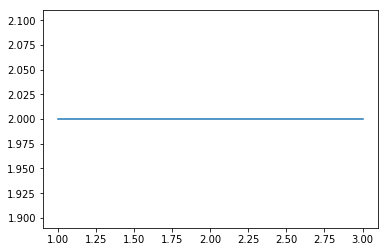

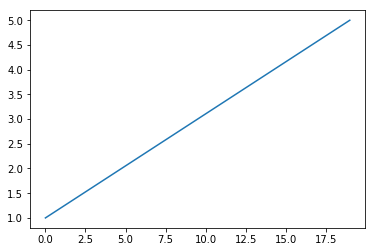

In [57]:
plt.plot([1,2,3], [2,2,2])
plt.show()

plt.plot(np.linspace(1, 5, 20))
plt.show()

# 3. Modeling

In [208]:
MAX_LENGTH = 10
USE_CUDA = False

# The Encoder

In [194]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden) #output: Y_i, hidden: S_i
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

# Attention

### Implementing the Bahdanau et al. model

In summary our decoder should consist of four main parts - an embedding layer turning an input word into a vector; a layer to calculate the attention energy per encoder output; a RNN layer; and an output layer.

The decoder's inputs are the last RNN hidden state $s_{i-1}$, last output $y_{i-1}$, and all encoder outputs $h_*$.

* embedding layer with inputs $y_{i-1}$
    * `embedded = embedding(last_rnn_output)`
* attention layer $a$ with inputs $(s_{i-1}, h_j)$ and outputs $e_{ij}$, normalized to create $a_{ij}$
    * `attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])`
    * `attn_weights = normalize(attn_energies)`
* context vector $c_i$ as an attention-weighted average of encoder outputs
    * `context = sum(attn_weights * encoder_outputs)`
* RNN layer(s) $f$ with inputs $(s_{i-1}, y_{i-1}, c_i)$ and internal hidden state, outputting $s_i$
    * `rnn_input = concat(embedded, context)`
    * `rnn_output, rnn_hidden = rnn(rnn_input, last_hidden)`
* an output layer $g$ with inputs $(y_{i-1}, s_i, c_i)$, outputting $y_i$
    * `output = out(embedded, rnn_output, context)`

In [195]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        #Define Param
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        #Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.attn = GeneralAttn(hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        #Get the embeddings of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        word_embedded = self.dropout(word_embedded)
        
        # Calculate attention weights and apply to encoder outputs
        attn_weights = self.attn(last_hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat((word_embedded, context), 2)
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(torch.cat((output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights
        
        
# embedded = embedding(last_rnn_output) # $y_{i-1}$
# attn_energies[j] = attn_layer(last_hidden, encoder_outputs[j])
# attn_weights = normalize(attn_energies)

# context = sum(attn_weights * encoder_outputs[j])

# #input (s_{i-1}, y_{i-1}, c_i) -> output = s_i
# rnn_input = concat(embedded, context)
# rnn_output, rnn_hidden = rnn(rnn_input last_hidden)

# #output layer g (fully connected) inputs(y_{i-1}, s_i, c_i) -> output = y_i
# output = out(embedded, rnn_output, context)

### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$




The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [196]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
            
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))
            
    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)
        
        #변수를 생성하여, attention energy를 저장하자
        attn_energies = Variable(torch.zeros(seq_len)) #B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()
        
        #각각의 encoder output의 에너지들을 저장한다.
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])
        
        # Normalize energies to weights in range 0~1, resize to 1x1xseq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy    


# Decoder

In [200]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, \
                 dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep param for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        #Define Layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, \
                         dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size) #why hidden * 2
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
        
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        
        #현재 input word (last output word)의 임베딩 가져오기
        word_embedded = self.embedding(word_input).view(1,1,-1) # S=1 x B x N
        
        #embedded input과 last context를 결합하고, RNN으로 Run한다.
        run_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        run_output, hidden = self.gru(rnn_input, last_hidden)
        
        # 현 RNN State와 모든 인코더 결과를 적용하여 어텐션을 구함. 인코더 출력에 적용
        attn_weights = self.attn(rnn_output.sueeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # final output, hidden state, attention weights 돌려주기
        
        return output, context, hidden, attn_weights      
        

# Model Test

- Encoder와 Decoder가 잘돌아가는지 확인해보자

In [209]:
encoder_test = EncoderRNN(10, 10, 2)
decoder_test = AttnDecoderRNN('general', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear(in_features=20, out_features=10)
  (attn): Attn(
    (attn): Linear(in_features=10, out_features=10)
  )
)


NameError: name 'rnn_input' is not defined

In [ ]:
# embbeded input word 합치고 last conetxt에서 RNN
rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
rnn_output, hidden = self.gru(rnn_input, last_hidden)

#Final output layer (next word prediction) using the RNN hidden state & context
rnn_ouput = rnn_output.squeeze(0) # S=1 x B x N -> B x N
context = context.squeeze(1) # B x S=1 x N -> B x N
output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))

# Return final output, hidden state, and attention weights (for vis)
return output, context, hidden, attn_weights

In [176]:
#view사용법

x = torch.randn(4, 4)
x.size()
y = x.view(16)
y.size()
#torch.Size([16])
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
z.size()
#torch.Size([2, 8])

#x.view(1,-1,1)
#squeeze 사용법

# Returns a `Tensor` with all the dimensions of :attr:`input` of size `1` removed.

# If `input` is of shape: :math:`(A x 1 x B x C x 1 x D)` then the `out` Tensor
# will be of shape: :math:`(A x B x C x D)`

x = torch.zeros(2,1,2,1,2)
x.size()
#(2L, 1L, 2L, 1L, 2L)
y = torch.squeeze(x)
y.size()
#(2L, 2L, 2L)
y = torch.squeeze(x, 0)
y.size()
#(2L, 1L, 2L, 1L, 2L)
y = torch.squeeze(x, 1)
y.size()
#(2L, 2L, 1L, 2L)


-0.8446 -0.7363  1.3560  0.9912
-1.7524 -1.9174 -0.6415  1.5273
-1.1230  0.8586  0.5614 -1.1767
-1.2801 -2.0209  2.4735  0.2755
[torch.FloatTensor of size 4x4]

In [43]:
train[:5]
len(train)

0

In [49]:
HIDDEN_SIZE = 100
N_LAYERS = 1
BATCH_SIZE = 1
N_EPOCH = 100
N_CHARS = 128  # ASCII

In [54]:
# Simple test to show how our network works
def test():
    encoder_hidden = encoder.init_hidden()
    word_input = str2tensor('hello')
    encoder_outputs, encoder_hidden = encoder(word_input, encoder_hidden)
    print(encoder_outputs)

    decoder_hidden = encoder_hidden

    word_target = str2tensor('pytorch')
    for c in range(len(word_target)):
        decoder_output, decoder_hidden = decoder(
            word_target[c], decoder_hidden)
        print(decoder_output.size(), decoder_hidden.size())

In [64]:
train_loader = DataLoader(dataset=TextDataset(),
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         num_workers=2)

In [67]:
for i, (srcs, targets) in enumerate(train_loader):
    print(i, srcs, targets)

0 ('thisnightyoushallbeholdhimatourfeast;',) ('This night you shall behold him at our feast;',)
1 ('itismysoulthatcallsuponmyname:',) ('It is my soul that calls upon my name:',)
2 ('ah,warwick,warwick!wertthouasweare.',) ('Ah, Warwick, Warwick! wert thou as we are.',)
3 ('shouldbeasholyassevere;',) ('Should be as holy as severe;',)
4 ('andfindinghim,thesearchersofthetown,',) ('And finding him, the searchers of the town,',)
5 ('letmeknowthepoint.',) ('Let me know the point.',)
6 ('how?',) ('How?',)
7 ('why,hownow,sonsandbrother!atastrife?',) ('Why, how now, sons and brother! at a strife?',)
8 ('capulet:',) ('CAPULET:',)
9 ('whythen,themustardwithoutthebeef.',) ('Why then, the mustard without the beef.',)
10 ('behold,behold.wheremadammitigationcomes!i',) ('Behold, behold. where Madam Mitigation comes! I',)
11 ('butwewilldrinktogether;andyoushallbear',) ('But we will drink together; and you shall bear',)
12 ('angelo:',) ('ANGELO:',)
13 ("ihopeall'sforthebest.",) ("I hope all's for the bes

552 ('him,thoughremovedfiftytimes,shallallcome',) ('him, though removed fifty times, shall all come',)
553 ('givememyromeo;and,whenheshalldie,',) ('Give me my Romeo; and, when he shall die,',)
554 ('withmodestwarrant.',) ('With modest warrant.',)
555 ('mustigoshowthemmyunbarbedsconce?',) ('Must I go show them my unbarbed sconce?',)
556 ('tocallthemwoollenvassals,thingscreated',) ('To call them woollen vassals, things created',)
557 ('hathcausedhisdeath:thewhichifwrongfully,',) ('Hath caused his death: the which if wrongfully,',)
558 ('tohavenoreyesnorearsnorthought,thensay',) ('To have nor eyes nor ears nor thought, then say',)
559 ('pompey:',) ('POMPEY:',)
560 ('now,sister,letushearyourfirmresolve.',) ('Now, sister, let us hear your firm resolve.',)
561 ('provost:',) ('Provost:',)
562 ('fornowweoweallegianceuntohenry.',) ('For now we owe allegiance unto Henry.',)
563 ('bishopofely:',) ('BISHOP OF ELY:',)
564 ('tocarveoutdialsquaintly,pointbypoint,',) ('To carve out dials quaintly, poi

1435 ('dickyyourboy,thatwithhisgrumblingvoice',) ('Dicky your boy, that with his grumbling voice',)
1436 ('pardon,oldfather,mymistakingeyes,',) ('Pardon, old father, my mistaking eyes,',)
1437 ('why,amidead?doinotbreatheaman?',) ('Why, am I dead? do I not breathe a man?',)
1438 ('thistrickmaychancetoscatheyou,iknowwhat:',) ('This trick may chance to scathe you, I know what:',)
1439 ("thatpagesblush'dathimandmenofheart",) ("That pages blush'd at him and men of heart",)
1440 ('thatmortalearsmighthardlyendurethedin?',) ('That mortal ears might hardly endure the din?',)
1441 ('thatisyourpart:yetiamadvisedtodoit;',) ('That is your part: yet I am advised to do it;',)
1442 ('restrainedtokeephimfromstumbling,hathbeen',) ('restrained to keep him from stumbling, hath been',)
1443 ('only,thisone:lordangeloisprecise;',) ('Only, this one: Lord Angelo is precise;',)
1444 ('infaith,iwill.letmeperusethisface.',) ('In faith, I will. Let me peruse this face.',)
1445 ('atelyhouse.',) ('At Ely House.',)
1

2265 ('andstraightdisclaimtheirtongues?whatare',) ('And straight disclaim their tongues? What are',)
2266 ("whatifhehadsaid'widoweraeneas'too?goodlord,",) ("What if he had said 'widower AEneas' too? Good Lord,",)
2267 ('wewillhaveringsandthingsandfinearray;',) ('We will have rings and things and fine array;',)
2268 ('comefrompisa,andishereatthedoortospeakwithhim.',) ('come from Pisa, and is here at the door to speak with him.',)
2269 ('grumio:',) ('GRUMIO:',)
2270 ('so,thegoodhorseismine.',) ('So, the good horse is mine.',)
2271 ('ferdinand:',) ('FERDINAND:',)
2272 ('florizel:',) ('FLORIZEL:',)
2273 ('autolycus:',) ('AUTOLYCUS:',)
2274 ('shouldwebesilentandnotspeak,ourraiment',) ('Should we be silent and not speak, our raiment',)
2275 ("butwhethertheybeta'enorslainwehearnot.",) ("But whether they be ta'en or slain we hear not.",)
2276 ('ortotheirownperdition.',) ('Or to their own perdition.',)
2277 ('lordgeorgeyourbrother,norfolkandmyself,',) ('Lord George your brother, Norfolk and mys

3210 ('indeepdesignsandmattersofgreatmoment,',) ('In deep designs and matters of great moment,',)
3211 ('moreholyandprofound,thanmineownlife,',) ('More holy and profound, than mine own life,',)
3212 ('andthatsamevengeancedothhehurlonthee,',) ('And that same vengeance doth he hurl on thee,',)
3213 ('exeter:',) ('EXETER:',)
3214 ('forbothofyouarebirdsofselfsamefeather.',) ('For both of you are birds of selfsame feather.',)
3215 ('bothtribunes:',) ('Both Tribunes:',)
3216 ("i'llframeconvenientpeace.now,goodaufidius,",) ("I'll frame convenient peace. Now, good Aufidius,",)
3217 ('mylordofsurrey,whylookyousosad?',) ('My Lord of Surrey, why look you so sad?',)
3218 ("i'llnotrememberyouofmyownlord,",) ("I'll not remember you of my own lord,",)
3219 ('whatishermother?',) ('What is her mother?',)
3220 ('hortensio:',) ('HORTENSIO:',)
3221 ('gloucester:',) ('GLOUCESTER:',)
3222 ('petruchio:',) ('PETRUCHIO:',)
3223 ('farewellatonce,foronce,forall,andever.',) ('Farewell at once, for once, for all, 

3849 ('sampson:',) ('SAMPSON:',)
3850 ('yeaevenmyfoeswillshedfast-fallingtears,',) ('Yea even my foes will shed fast-falling tears,',)
3851 ('himselfwithhisgoodarmsinlustystroke',) ('Himself with his good arms in lusty stroke',)
3852 ('kinglewis,ihereprotest,insightofheaven,',) ('King Lewis, I here protest, in sight of heaven,',)
3853 ('willissueoutagainandbidusbattle:',) ('Will issue out again and bid us battle:',)
3854 ('awhilewiththemaid:mymindpromiseswithmy',) ('awhile with the maid: my mind promises with my',)
3855 ("ifyoubeone,asyouarewellexpress'd",) ("If you be one, as you are well express'd",)
3856 ('prospero:',) ('PROSPERO:',)
3857 ('fortythousandfathomabovewater,andsungthis',) ('forty thousand fathom above water, and sung this',)
3858 ('ariel:',) ('ARIEL:',)
3859 ('servant:',) ('Servant:',)
3860 ("o,youarenovices!'tisaworldtosee,",) ("O, you are novices! 'tis a world to see,",)
3861 ("withitssweetair:thenceihavefollow'dit,",) ("With its sweet air: thence I have follow'd it,"

4462 ('thyschool-daysfrightful,desperate,wild,andfurious,',) ('Thy school-days frightful, desperate, wild, and furious,',)
4463 ('secondmurderer:',) ('Second Murderer:',)
4464 ('especiallytoknowhimself.',) ('especially to know himself.',)
4465 ("hathpublish'dandproclaim'ditopenly:",) ("Hath publish'd and proclaim'd it openly:",)
4466 ('iknowhimforamandivineandholy;',) ('I know him for a man divine and holy;',)
4467 ('andonlyhitherward.ileaveyourhonours.',) ('And only hitherward. I leave your honours.',)
4468 ('peter:',) ('PETER:',)
4469 ('andsaypoormargaretwasaprophetess!',) ('And say poor Margaret was a prophetess!',)
4470 ('makenottoorashatrialofhim,for',) ('Make not too rash a trial of him, for',)
4471 ("ifnot,i'llusetheadvantageofmypower",) ("If not, I'll use the advantage of my power",)
4472 ('andedward,mypoorson,attewksbury.',) ('And Edward, my poor son, at Tewksbury.',)
4473 ('petruchio:',) ('PETRUCHIO:',)
4474 ('buthe,mylord,isgonetoravenspurgh,',) ('But he, my lord, is gone to

5313 ('allsoulsthatwillbesafeflyfrommyside,',) ('All souls that will be safe fly from my side,',)
5314 ('grumio:',) ('GRUMIO:',)
5315 ('andforthesegreataffairsdoasksomecharge,',) ('And for these great affairs do ask some charge,',)
5316 ('whydowefingerthus?icannotrest',) ('Why do we finger thus? I cannot rest',)
5317 ('ispeakamazedly;anditbecomes',) ('I speak amazedly; and it becomes',)
5318 ('wordsagainstme?thisisagoodfriar,belike!',) ('Words against me? this is a good friar, belike!',)
5319 ('menenius:',) ('MENENIUS:',)
5320 ('ay,nowmethinksiheargreatwarwickspeak:',) ('Ay, now methinks I hear great Warwick speak:',)
5321 ("andi'llnotwishtheetoher.",) ("And I'll not wish thee to her.",)
5322 ('tireonthefleshofmeandofmyson!',) ('Tire on the flesh of me and of my son!',)
5323 ('ihavenobrother,iamlikenobrother;',) ('I have no brother, I am like no brother;',)
5324 ('nurse:',) ('Nurse:',)
5325 ('come,mustermen:mycounselismyshield;',) ('Come, muster men: my counsel is my shield;',)
5326 ('

6316 ('buthowisitthatgreatplantagenet',) ('But how is it that great Plantagenet',)
6317 ('lucentio:',) ('LUCENTIO:',)
6318 ('marcius:',) ('MARCIUS:',)
6319 ("thatshe'sthechosenofsigniorhortensio.",) ("That she's the chosen of Signior Hortensio.",)
6320 ('lucio:',) ('LUCIO:',)
6321 ('no,no:thisshallforbidit:liethouthere.',) ('No, no: this shall forbid it: lie thou there.',)
6322 ('howmanychildrenhastthou,widow?tellme.',) ('How many children hast thou, widow? tell me.',)
6323 ('hortensio:',) ('HORTENSIO:',)
6324 ('andiamgoingwithinstructiontohim.',) ('And I am going with instruction to him.',)
6325 ('staybutalittle,iwillcomeagain.',) ('Stay but a little, I will come again.',)
6326 ('george:',) ('GEORGE:',)
6327 ('thanbuckinghamandhisrash-leviedarmy.',) ('Than Buckingham and his rash-levied army.',)
6328 ('thyservicesbyleavingmenow:theneedihaveof',) ('thy services by leaving me now: the need I have of',)
6329 ('theysayonewouldspeaktoherandstandinhopeof',) ('they say one would speak to her

6928 ('single:yourabilitiesaretooinfant-likefor',) ('single: your abilities are too infant-like for',)
6929 ('clifford:',) ('CLIFFORD:',)
6930 ('harry,howfaresyouruncle?',) ('Harry, how fares your uncle?',)
6931 ("thetownista'en!",) ("The town is ta'en!",)
6932 ('comeon,mymasters,eachmantakehisstand:',) ('Come on, my masters, each man take his stand:',)
6933 ('thecommoners,forwhomwestand,butthey',) ('The commoners, for whom we stand, but they',)
6934 ('orichard!yorkistoofargonewithgrief,',) ('O Richard! York is too far gone with grief,',)
6935 ('themereeffusionofthyproperloins,',) ('The mere effusion of thy proper loins,',)
6936 ('maybeg;fourpoundofprunes,andasmanyof',) ('may beg; four pound of prunes, and as many of',)
6937 ('withoutmoremercy,toitsownprotection',) ('Without more mercy, to its own protection',)
6938 ('gloucester:',) ('GLOUCESTER:',)
6939 ('morehomelythanthystate.forthee,fondboy,',) ('More homely than thy state. For thee, fond boy,',)
6940 ('autolycus:',) ('AUTOLYCUS:',

7608 ('sirchristopher,tellrichmondthisfromme:',) ('Sir Christopher, tell Richmond this from me:',)
7609 ('camillo:',) ('CAMILLO:',)
7610 ('dukevincentio:',) ('DUKE VINCENTIO:',)
7611 ('yes,iknowtheetobesigniorlucentio.',) ('Yes, I know thee to be Signior Lucentio.',)
7612 ('queenelizabeth:',) ('QUEEN ELIZABETH:',)
7613 ("thatthouwertcauseofnoblegloucester'sdeath.",) ("That thou wert cause of noble Gloucester's death.",)
7614 ('sampson:',) ('SAMPSON:',)
7615 ("andthisword'love,'whichgraybeardscalldivine,",) ("And this word 'love,' which graybeards call divine,",)
7616 ('thatbucketdownandfulloftearsami,',) ('That bucket down and full of tears am I,',)
7617 ('well,gentlemen,',) ('Well, gentlemen,',)
7618 ('oldsir,iknow',) ('Old sir, I know',)
7619 ('menenius:',) ('MENENIUS:',)
7620 ('volsce:',) ('Volsce:',)
7621 ('theangrylaw;donostaintoyourowngracious',) ('the angry law; do no stain to your own gracious',)
7622 ('butassuccessivelyfrombloodtoblood,',) ('But as successively from blood to b

8255 ('houseofher!comeon.',) ('house of her! Come on.',)
8256 ('leontes:',) ('LEONTES:',)
8257 ('angelo:',) ('ANGELO:',)
8258 ("inearnest,it'strue;iheardasenatorspeakit.",) ("In earnest, it's true; I heard a senator speak it.",)
8259 ('tillitwaswhettedonthystone-hardheart,',) ('Till it was whetted on thy stone-hard heart,',)
8260 ('brutus:',) ('BRUTUS:',)
8261 ("methinksthouspeak'stnotwell.",) ("Methinks thou speak'st not well.",)
8262 ('counterfeitassurance:takeyouassuranceofher,',) ('counterfeit assurance: take you assurance of her,',)
8263 ('firstlord:',) ('First Lord:',)
8264 ('cometopass,saypompeytoldyouso.',) ('come to pass, say Pompey told you so.',)
8265 ('queenmargaret:',) ('QUEEN MARGARET:',)
8266 ('yourhonour.',) ('your honour.',)
8267 ('mytrafficissheets;whenthekitebuilds,lookto',) ('My traffic is sheets; when the kite builds, look to',)
8268 ('catesby:',) ('CATESBY:',)
8269 ('thatwhenshedieswithbeautydiesherstore.',) ('That when she dies with beauty dies her store.',)
8270

8997 ('lucentio:',) ('LUCENTIO:',)
8998 ('butwithalingeringdramthatshouldnotwork',) ('But with a lingering dram that should not work',)
8999 ('pompey:',) ('POMPEY:',)
9000 ('tobatemeafullyear.',) ('To bate me a full year.',)
9001 ("notthatipityhenry'smisery,",) ("Not that I pity Henry's misery,",)
9002 ("whatlatemisfortuneisbefall'nkingedward?",) ("What late misfortune is befall'n King Edward?",)
9003 ("whichthouforget'st.thisdamn'dwitchsycorax,",) ("Which thou forget'st. This damn'd witch Sycorax,",)
9004 ('inthatdimmonumentwheretybaltlies.',) ('In that dim monument where Tybalt lies.',)
9005 ('ifthoubeestcapableofthingsserious,thoumust',) ('if thou beest capable of things serious, thou must',)
9006 ('thetruthofthisappear.prepareyou,lords;',) ('The truth of this appear. Prepare you, lords;',)
9007 ("hail,lords!iamreturn'dyoursoldier,",) ("Hail, lords! I am return'd your soldier,",)
9008 ('queenmargaret:',) ('QUEEN MARGARET:',)
9009 ('whatservicewiltthoudome,ifigivethem?',) ('What serv

9817 ('mybrother;whoselossofhismostpreciousqueen',) ('my brother; whose loss of his most precious queen',)
9818 ('goodmylord,becured',) ('Good my lord, be cured',)
9819 ('thatnomanshallhaveprivateconference,',) ('That no man shall have private conference,',)
9820 ('whybrotherrivers,areyouyettolearn',) ('Why brother Rivers, are you yet to learn',)
9821 ('exeter:',) ('EXETER:',)
9822 ('ishall,sir.fareyouwell.',) ('I shall, sir. Fare you well.',)
9823 ('to-morrow,inmineopinion,istoosudden;',) ('To-morrow, in mine opinion, is too sudden;',)
9824 ('alas,myliege,mywifeisdeadto-night;',) ('Alas, my liege, my wife is dead to-night;',)
9825 ('theruthlessqueengavehimtodryhischeeks',) ('The ruthless queen gave him to dry his cheeks',)
9826 ('how!darenot!donot.doyouknow,anddarenot?',) ('How! dare not! do not. Do you know, and dare not?',)
9827 ('andgivemeleave,',) ('And give me leave,',)
9828 ('doesbridgetpaintstill,pompey,ha?',) ('Does Bridget paint still, Pompey, ha?',)
9829 ('oxford:',) ('OXFOR

10475 ('thygrandfather,rogermortimer,earlofmarch:',) ('Thy grandfather, Roger Mortimer, Earl of March:',)
10476 ("sayeither,andi'llstaythecircumstance:",) ("Say either, and I'll stay the circumstance:",)
10477 ('justice,sir,anddobringinherebeforeyourgood',) ('justice, sir, and do bring in here before your good',)
10478 ('youmaypartakeofanythingwesay:',) ('You may partake of any thing we say:',)
10479 ('onethreeofthem,bytheirownreport,sir,hath',) ('One three of them, by their own report, sir, hath',)
10480 ('ihaveahundredmilch-kinetothepail,',) ('I have a hundred milch-kine to the pail,',)
10481 ('madam,goodhope;hisgracespeakscheerfully.',) ('Madam, good hope; his grace speaks cheerfully.',)
10482 ("why,thousay'sttrue;itisapaltrycap,",) ("Why, thou say'st true; it is a paltry cap,",)
10483 ('warwick:',) ('WARWICK:',)
10484 ('thecoveringskyisnothing;bohemianothing;',) ('The covering sky is nothing; Bohemia nothing;',)
10485 ('gloucester:',) ('GLOUCESTER:',)
10486 ('thathorsethatthousooft

11187 ('iamcontent:richardplantagenet,',) ('I am content: Richard Plantagenet,',)
11188 ('mamillius:',) ('MAMILLIUS:',)
11189 ("islecherysolook'dafter?",) ("Is lechery so look'd after?",)
11190 ("'itisashardtocomeasforacamel",) ("'It is as hard to come as for a camel",)
11191 ('thenreasonsafelywithyou.therefore,beitknown,',) ('Then reason safely with you. Therefore, be it known,',)
11192 ('menenius:',) ('MENENIUS:',)
11193 ('secondsenator:',) ('Second Senator:',)
11194 ("tohave'twithsaying'goodmorrow.'",) ("To have't with saying 'Good morrow.'",)
11195 ('didstnoteit?',) ('Didst note it?',)
11196 ('whereourrightvaliantfatherisbecome.',) ('Where our right valiant father is become.',)
11197 ('thisnewsismortaltothequeen:lookdown',) ('This news is mortal to the queen: look down',)
11198 ('kingrichardiii:',) ('KING RICHARD III:',)
11199 ('giveupyourbodytosuchsweetuncleanness',) ('Give up your body to such sweet uncleanness',)
11200 ('hadpartinthisfairmaid;nowheavenhathall,',) ('Had part in t

11877 ('menenius:',) ('MENENIUS:',)
11878 ('thisboy,thatcannottellwhathewouldhave',) ('This boy, that cannot tell what he would have',)
11879 ('neighboursandfriends,thoughbrideand',) ('Neighbours and friends, though bride and',)
11880 ('addanimmortaltitletoyourcrown!',) ('Add an immortal title to your crown!',)
11881 ('thegodsgrantthemtrue!',) ('The gods grant them true!',)
11882 ("fellsorrow'stoothdothneverranklemore",) ("Fell sorrow's tooth doth never rankle more",)
11883 ('paulina:',) ('PAULINA:',)
11884 ('tush,thouartdeceived:',) ('Tush, thou art deceived:',)
11885 ('spavins,rayedwithyellows,pastcureofthefives,',) ('spavins, rayed with yellows, past cure of the fives,',)
11886 ('butaftermanyceremoniesdone,',) ('But after many ceremonies done,',)
11887 ('thatwillnotholdthehandling:orsaytothem,',) ('That will not hold the handling: or say to them,',)
11888 ('grumio:',) ('GRUMIO:',)
11889 ('savethatriotousyouth,withdangeroussense,',) ('Save that riotous youth, with dangerous sense,',)

12504 ("tojuliet'sgrave;fortheremustiusethee.",) ("To Juliet's grave; for there must I use thee.",)
12505 ('pompey:',) ('POMPEY:',)
12506 ('unlessyoucallitgoodtopityhim,',) ('Unless you call it good to pity him,',)
12507 ('pritheenow,sayyouwill,andgoaboutit.',) ('Prithee now, say you will, and go about it.',)
12508 ('firstmurderer:',) ('First Murderer:',)
12509 ("thatknowthestrong'standsurestwaytoget.",) ("That know the strong'st and surest way to get.",)
12510 ("goseethisrumourerwhipp'd.itcannotbe",) ("Go see this rumourer whipp'd. It cannot be",)
12511 ('hehathnotmoneyfortheseirishwars,',) ('He hath not money for these Irish wars,',)
12512 ('brutus:',) ('BRUTUS:',)
12513 ('clarence:',) ('CLARENCE:',)
12514 ('kingrichardiii:',) ('KING RICHARD III:',)
12515 ("tohavenoscreenbetweenthispartheplay'd",) ("To have no screen between this part he play'd",)
12516 ('what,younotoriousvillain,didstthouneversee',) ('What, you notorious villain, didst thou never see',)
12517 ("astobehush'dandnought

13091 ('imustbepatienttilltheheavenslook',) ('I must be patient till the heavens look',)
13092 ('cannotbeabletoexpressit.',) ('cannot be able to express it.',)
13093 ('thanthisofjulietandherromeo.',) ('Than this of Juliet and her Romeo.',)
13094 ('dukeofaumerle:',) ('DUKE OF AUMERLE:',)
13095 ('alikebetwitchedbythecharmoflooks,',) ('Alike betwitched by the charm of looks,',)
13096 ('welcome,harry:what,willnotthiscastleyield?',) ('Welcome, Harry: what, will not this castle yield?',)
13097 ('howfaresourgraciouslady?',) ('How fares our gracious lady?',)
13098 ('nurse:',) ('Nurse:',)
13099 ('theright:buttothepoint.asisay,this',) ('the right: but to the point. As I say, this',)
13100 ('byaccidentmoststrange,bountifulfortune,',) ('By accident most strange, bountiful Fortune,',)
13101 ('thatthislivesinthymind?whatseestthouelse',) ('That this lives in thy mind? What seest thou else',)
13102 ("what'shethatnowisgoingoutofdoor?",) ("What's he that now is going out of door?",)
13103 ('conductmetot

13705 ('pawntillitbebroughtyou.',) ('pawn till it be brought you.',)
13706 ('whereishe,hearyou?',) ('Where is he, hear you?',)
13707 ('thisblessedplot,thisearth,thisrealm,thisengland,',) ('This blessed plot, this earth, this realm, this England,',)
13708 ('so,liethouthere:diethou,anddieourfear;',) ('So, lie thou there: die thou, and die our fear;',)
13709 ('o,whocanholdafireinhishand',) ('O, who can hold a fire in his hand',)
13710 ('sovereign,hereliesthecountyparisslain;',) ('Sovereign, here lies the County Paris slain;',)
13711 ('she-wolfoffrance,butworsethanwolvesoffrance,',) ('She-wolf of France, but worse than wolves of France,',)
13712 ('hereafter,whichshallthenhavenopowertostand',) ('hereafter, which shall then have no power to stand',)
13713 ('hathbroughtmetothyhearth;notoutofhope--',) ('Hath brought me to thy hearth; not out of hope--',)
13714 ('speaktomygossipvenusonefairword,',) ('Speak to my gossip Venus one fair word,',)
13715 ('ismymasterandhiswifecoming,grumio?',) ('Is m

14704 ('butwiththatsurname;agoodmemory,',) ('But with that surname; a good memory,',)
14705 ('ereiagainbeholdmyromeo!',) ('Ere I again behold my Romeo!',)
14706 ('gentlemen:',) ('GENTLEMEN:',)
14707 ('cominius:',) ('COMINIUS:',)
14708 ('leontes:',) ('LEONTES:',)
14709 ('true!pow,wow.',) ('True! pow, wow.',)
14710 ('frenchwoman.',) ('Frenchwoman.',)
14711 ('itshouldtakejoy',) ('it should take joy',)
14712 ('firstsoldier:',) ('First Soldier:',)
14713 ('benvolio:',) ('BENVOLIO:',)
14714 ('lucentio:',) ('LUCENTIO:',)
14715 ('hadstbeenpoorjohn.drawthytool!herecomes',) ('hadst been poor John. Draw thy tool! here comes',)
14716 ('none,sir;ihavenopheasant,cocknorhen.',) ('None, sir; I have no pheasant, cock nor hen.',)
14717 ('oisabel,willyounotlendaknee?',) ('O Isabel, will you not lend a knee?',)
14718 ('why,foolishboy,thekingisleftbehind,',) ('Why, foolish boy, the king is left behind,',)
14719 ("what,artthoustiff?stand'stout?",) ("What, art thou stiff? stand'st out?",)
14720 ('barkloughlyc

15279 ('hastingtothecourt.',) ('Hasting to the court.',)
15280 ('menenius:',) ('MENENIUS:',)
15281 ('foryethishonourneverheardaplay--',) ('For yet his honour never heard a play--',)
15282 ('ay,withsuchgiftsthatheavenshallsharewithyou.',) ('Ay, with such gifts that heaven shall share with you.',)
15283 ('theinsideofyourpursetotheoutsideofhishand,',) ('the inside of your purse to the outside of his hand,',)
15284 ('well,well,nomore.',) ('Well, well, no more.',)
15285 ('verywellmended.kisshimforthat,goodwidow.',) ('Very well mended. Kiss him for that, good widow.',)
15286 ('thatcalumnydothuse--o,iamout--',) ('That calumny doth use--O, I am out--',)
15287 ('kinghenryvi:',) ('KING HENRY VI:',)
15288 ('thoudrownthesadremembranceofthosewrongs',) ('Thou drown the sad remembrance of those wrongs',)
15289 ('myliege,oldgauntcommendshimtoyourmajesty.',) ('My liege, old Gaunt commends him to your majesty.',)
15290 ('andithis.',) ('And I this.',)
15291 ('sowewept,andtherewasthefirstgentleman-like',)

15793 ('secondmurderer:',) ('Second Murderer:',)
15794 ('ifeveryouhavespenttimeworseerenow;',) ('If ever you have spent time worse ere now;',)
15795 ('andstillrestthine.thestormbegins;poorwretch,',) ('And still rest thine. The storm begins; poor wretch,',)
15796 ('hemustbeforethedeputy,sir;hehasgivenhim',) ('He must before the deputy, sir; he has given him',)
15797 ('wouldseembutmodest:therefore,ibeseechyou',) ('Would seem but modest: therefore, I beseech you',)
15798 ("youleftpoorhenryatthebishop'spalace,",) ("You left poor Henry at the Bishop's palace,",)
15799 ('iforanedwardweep,sodonotthey:',) ('I for an Edward weep, so do not they:',)
15800 ('catesby:',) ('CATESBY:',)
15801 ('andwanderwetoseethyhonestson,',) ('And wander we to see thy honest son,',)
15802 ('kinghenryandtheprincehissonaregone:',) ('King Henry and the prince his son are gone:',)
15803 ('andiwillmaketheethinkthyswanacrow.',) ('And I will make thee think thy swan a crow.',)
15804 ('assurfeitisthefatherofmuchfast,',) (

16569 ('york:',) ('YORK:',)
16570 ('autolycus:',) ('AUTOLYCUS:',)
16571 ('uponthispresentaction.',) ('Upon this present action.',)
16572 ('whocandogoodonhim?',) ('Who can do good on him?',)
16573 ('secondsenator:',) ('Second Senator:',)
16574 ('leontes:',) ('LEONTES:',)
16575 ('butquickandinminearms.come,takeyourflowers:',) ('But quick and in mine arms. Come, take your flowers:',)
16576 ('montague:',) ('MONTAGUE:',)
16577 ('juliet:',) ('JULIET:',)
16578 ('betwixtthedukeofgloucesterandyourbrothers,',) ('Betwixt the Duke of Gloucester and your brothers,',)
16579 ('wheni,thythree-hourswife,havemangledit?',) ('When I, thy three-hours wife, have mangled it?',)
16580 ('lendfavourableearstoourrequest;',) ('Lend favourable ears to our request;',)
16581 ('and,look,wheniamking,claimthouofme',) ('And, look, when I am king, claim thou of me',)
16582 ('prince:icannottell,goodsir,forwhichofhis',) ('prince: I cannot tell, good sir, for which of his',)
16583 ('isabella:',) ('ISABELLA:',)
16584 ('puton

17374 ('withalobdurate,donothearhimplead;',) ('Withal obdurate, do not hear him plead;',)
17375 ('ihavenomoresonsoftheroyalblood',) ('I have no more sons of the royal blood',)
17376 ('butonthysideimaynotbetooforward',) ('But on thy side I may not be too forward',)
17377 ('gothou,andfillanotherroominhell.',) ('Go thou, and fill another room in hell.',)
17378 ('hortensio:',) ('HORTENSIO:',)
17379 ('sincewhen,hisoathisbroke;for,asihear,',) ('Since when, his oath is broke; for, as I hear,',)
17380 ('clifford:',) ('CLIFFORD:',)
17381 ('youwouldhavethoughttheverywindowsspake,',) ('You would have thought the very windows spake,',)
17382 ('baptista:',) ('BAPTISTA:',)
17383 ("thereforewe'llhavesomehalfadozenfriends,",) ("Therefore we'll have some half a dozen friends,",)
17384 ('andbakestheelflocksinfoulsluttishhairs,',) ('And bakes the elflocks in foul sluttish hairs,',)
17385 ('buckingham:',) ('BUCKINGHAM:',)
17386 ('ourprayerstothegods,whichisacomfort',) ('Our prayers to the gods, which is a

18217 ("well,i'llhearit,sir:yetyoumustnotthinkto",) ("Well, I'll hear it, sir: yet you must not think to",)
18218 ('henrybolingbroke:',) ('HENRY BOLINGBROKE:',)
18219 ('lord:',) ('Lord:',)
18220 ("andsay'whatis'tyourhonourwillcommand,",) ("And say 'What is't your honour will command,",)
18221 ('ipritheegoandgetmesomerepast;',) ('I prithee go and get me some repast;',)
18222 ('clown:',) ('Clown:',)
18223 ('asifmybrotherlived:ipartlythink',) ('As if my brother lived: I partly think',)
18224 ('ironofnapleshidwithenglishgilt,',) ('Iron of Naples hid with English gilt,',)
18225 ('pompey:',) ('POMPEY:',)
18226 ('whenshewilltakethereiniletherrun;',) ('When she will take the rein I let her run;',)
18227 ('thatwillthekingseverelyprosecute',) ('That will the king severely prosecute',)
18228 ('oncemoretolookonhim.',) ('Once more to look on him.',)
18229 ('ghostsofyoungprinces:',) ('Ghosts of young Princes:',)
18230 ('tomeetanon,uponyourapprobation.',) ('To meet anon, upon your approbation.',)
182

19021 ("bastardchildrenthanwar'sadestroyerofmen.",) ("bastard children than war's a destroyer of men.",)
19022 ('provost:',) ('Provost:',)
19023 ('lordmarshal:',) ('Lord Marshal:',)
19024 ('gonzalo:',) ('GONZALO:',)
19025 ('butslowinspeech,yetsweetasspring-timeflowers:',) ('But slow in speech, yet sweet as spring-time flowers:',)
19026 ('sir,',) ('Sir,',)
19027 ("andgrantofthewholetable.he'llgo,hesays,",) ("and grant of the whole table. He'll go, he says,",)
19028 ("loud'larums,neighingsteeds,andtrumpets'clang?",) ("Loud 'larums, neighing steeds, and trumpets' clang?",)
19029 ("'tisverytrue,mygriefliesallwithin;",) ("'Tis very true, my grief lies all within;",)
19030 ("whensteelgrowssoftastheparasite'ssilk,",) ("When steel grows soft as the parasite's silk,",)
19031 ('true,thinkyou?',) ('true, think you?',)
19032 ('katharina:',) ('KATHARINA:',)
19033 ('butbloodywiththeenemiesofhiskin.',) ('But bloody with the enemies of his kin.',)
19034 ('havefoughtwiththemen,iwillbecruelwiththe',) ('

19775 ('couldallbutanswerforthatpeevishbrat?',) ('Could all but answer for that peevish brat?',)
19776 ("that'sabravefellow;buthe'svengeanceproud,and",) ("That's a brave fellow; but he's vengeance proud, and",)
19777 ('unfoldtheimaginedhappinessthatboth',) ('Unfold the imagined happiness that both',)
19778 ("let'sallsinkwiththeking.",) ("Let's all sink with the king.",)
19779 ('asyoushallwellbesatisfiedwithal.',) ('As you shall well be satisfied withal.',)
19780 ('friarlaurence:',) ('FRIAR LAURENCE:',)
19781 ('menenius:',) ('MENENIUS:',)
19782 ('notlikethefruitofsuchagoodlytree.',) ('Not like the fruit of such a goodly tree.',)
19783 ('hiscurrishriddlessortnotwiththisplace.',) ('His currish riddles sort not with this place.',)
19784 ('godsaveyou,sir!',) ('God save you, sir!',)
19785 ('abraceofdraymenbidgodspeedhimwell',) ('A brace of draymen bid God speed him well',)
19786 ('sometardycrippleborethecountermand,',) ('Some tardy cripple bore the countermand,',)
19787 ('withthefashions,ful

20700 ('angelo:',) ('ANGELO:',)
20701 ('doevendragmehomeward:whichtohinder',) ('Do even drag me homeward: which to hinder',)
20702 ('moveslikeanengine,andthegroundshrinksbefore',) ('moves like an engine, and the ground shrinks before',)
20703 ('disputenotwithher;sheislunatic.',) ('Dispute not with her; she is lunatic.',)
20704 ('coriolanus:',) ('CORIOLANUS:',)
20705 ('somerset:',) ('SOMERSET:',)
20706 ('icalltheenot.',) ('I call thee not.',)
20707 ('ofyourcommissions.',) ('Of your commissions.',)
20708 ('theonebytheother.',) ('The one by the other.',)
20709 ('sir,itisthreedayssinceisawtheprince.what',) ('Sir, it is three days since I saw the prince. What',)
20710 ('inyourclosepatience.',) ('In your close patience.',)
20711 ('sicinius:',) ('SICINIUS:',)
20712 ("onthecurl'dclouds,tothystrongbiddingtask",) ("On the curl'd clouds, to thy strong bidding task",)
20713 ("'tislikethatrichmondwiththerestshalldown.",) ("'Tis like that Richmond with the rest shall down.",)
20714 ('bygivingliberty

21383 ('firstcitizen:',) ('First Citizen:',)
21384 ('towhom,mylord?',) ('To whom, my lord?',)
21385 ("tobebyoathenjoin'dtothis.farewell!",) ("To be by oath enjoin'd to this. Farewell!",)
21386 ("bysoreceivingadishonour'dlife",) ("By so receiving a dishonour'd life",)
21387 ('mywifeisslippery?ifthouwiltconfess,',) ('My wife is slippery? If thou wilt confess,',)
21388 ('ladygrey:',) ('LADY GREY:',)
21389 ('youmusttopomfret,notuntothetower.',) ('You must to Pomfret, not unto the Tower.',)
21390 ('wemustproceedaswedofindthepeople.',) ('We must proceed as we do find the people.',)
21391 ("i'moutofpatience.",) ("I'm out of patience.",)
21392 ('hispencil,andthepainterwithhisnets;butiam',) ('his pencil, and the painter with his nets; but I am',)
21393 ("theglassesofmysight!abeggar'stongue",) ("The glasses of my sight! a beggar's tongue",)
21394 ('andeveryhourmorecompetitors',) ('And every hour more competitors',)
21395 ('eithernew,orbyremissnessnew-conceived,',) ('Either new, or by remissness 

22195 ('forconsulships?',) ('for consulships?',)
22196 ('virgilia:',) ('VIRGILIA:',)
22197 ('prospero:',) ('PROSPERO:',)
22198 ('tarrysolong.butiwouldbeloathtofallinto',) ('tarry so long. But I would be loath to fall into',)
22199 ("i'lltelltheeaswepass;butthisipray,",) ("I'll tell thee as we pass; but this I pray,",)
22200 ('whatisthematter',) ('What is the matter',)
22201 ('heavenkeepyourhonoursafe!',) ('Heaven keep your honour safe!',)
22202 ('goodheart,atwhat?',) ('Good heart, at what?',)
22203 ('wereheasfamousandasboldinwar',) ('Were he as famous and as bold in war',)
22204 ('thanfaultsmayshakeourframes,--letmebebold;',) ('Than faults may shake our frames,--let me be bold;',)
22205 ("yes,certain,there'saletterforyou;isaw't.",) ("Yes, certain, there's a letter for you; I saw't.",)
22206 ('youknowtherewantsnojunketsatthefeast.',) ('You know there wants no junkets at the feast.',)
22207 ('andmostperniciouspurpose!seeming,seeming!',) ('And most pernicious purpose! Seeming, seeming!',)

22969 ('asmuchgoodstaywiththeeasgowithme!',) ('As much good stay with thee as go with me!',)
22970 ('thereisanartwhichintheirpiednessshares',) ('There is an art which in their piedness shares',)
22971 ('takecold.holla,ho!curtis.',) ('take cold. Holla, ho! Curtis.',)
22972 ('inthishardrock,whilesyoudokeepfromme',) ('In this hard rock, whiles you do keep from me',)
22973 ('maydomuchdanger.friarjohn,gohence;',) ('May do much danger. Friar John, go hence;',)
22974 ('menenius:',) ('MENENIUS:',)
22975 ('andeverytonguebringsinaseveraltale,',) ('And every tongue brings in a several tale,',)
22976 ('youwouldentreatmerathergothanstay.',) ('You would entreat me rather go than stay.',)
22977 ('thereismygage,themanualsealofdeath,',) ('There is my gage, the manual seal of death,',)
22978 ('makeshimspeakfondly,likeafranticman',) ('Makes him speak fondly, like a frantic man',)
22979 ('nathaniel:',) ('NATHANIEL:',)
22980 ("hisdaughter'strial!thathedidbutsee",) ("His daughter's trial! that he did but se

23415 ('icomeaboutmybrother.',) ('I come about my brother.',)
23416 ("evennowweheardthenews:ah,could'stthoufly!",) ("Even now we heard the news: ah, could'st thou fly!",)
23417 ('willyouweshowourtitletothecrown?',) ('Will you we show our title to the crown?',)
23418 ("hadslipp'dourclaimuntilanotherage.",) ("Had slipp'd our claim until another age.",)
23419 ('kingrichardii:',) ('KING RICHARD II:',)
23420 ("let'salong.",) ("Let's along.",)
23421 ('coriolanus:',) ('CORIOLANUS:',)
23422 ("butlookedbigandspitathim,he'ldhaverun.",) ("but looked big and spit at him, he'ld have run.",)
23423 ('ishouldbeguiltierthanmyguiltiness,',) ('I should be guiltier than my guiltiness,',)
23424 ('tovalentinus,rowland,andtocrassus,',) ('To Valentinus, Rowland, and to Crassus,',)
23425 ('andnoworldlysuitwouldhebemoved,',) ('And no worldly suit would he be moved,',)
23426 ('tut,yousawherfair,noneelsebeingby,',) ('Tut, you saw her fair, none else being by,',)
23427 ('andyet,tomyteethbeitspoken,ihavebutfour--',

24241 ('friarpeter:',) ('FRIAR PETER:',)
24242 ('so,so:farewell;wearegone.',) ('So, so: farewell; we are gone.',)
24243 ('againstafallingfabric.willyouhence,',) ('Against a falling fabric. Will you hence,',)
24244 ("goodnews,goodnews;theladieshaveprevail'd,",) ("Good news, good news; the ladies have prevail'd,",)
24245 ('ihaveforgotyourname;but,sure,thatpart',) ('I have forgot your name; but, sure, that part',)
24246 ('buckingham:',) ('BUCKINGHAM:',)
24247 ('orneverafterlookmeintheface:',) ('Or never after look me in the face:',)
24248 ('andbethywife--ifanybesomad--',) ('And be thy wife--if any be so mad--',)
24249 ('shouldnothingprivilegehim,norpartialize',) ('Should nothing privilege him, nor partialize',)
24250 ('shemayhelpyoutomanyfairpreferments,',) ('She may help you to many fair preferments,',)
24251 ("saw'stthouthemelancholylordnorthumberland?",) ("Saw'st thou the melancholy Lord Northumberland?",)
24252 ('sly:',) ('SLY:',)
24253 ('talknot,signiorgremio:isayheshallgotoprison.',

25291 ("muchcomfortin't;says'mypoorprisoner,",) ("Much comfort in't; says 'My poor prisoner,",)
25292 ('sicinius:',) ('SICINIUS:',)
25293 ('ah,gaunt,hisbloodwasthine!thatbed,thatwomb,',) ('Ah, Gaunt, his blood was thine! that bed, that womb,',)
25294 ("i'llnottorome,i'llbackwithyou;andprayyou,",) ("I'll not to Rome, I'll back with you; and pray you,",)
25295 ('tolayasidelife-harmingheaviness',) ('To lay aside life-harming heaviness',)
25296 ('andmakeadearthinthisrevoltingland.',) ('And make a dearth in this revolting land.',)
25297 ('andtellfalseedward,thysupposedking,',) ('And tell false Edward, thy supposed king,',)
25298 ('forthisdesign.whatcourseimeantohold',) ('For this design. What course I mean to hold',)
25299 ('thatshewascomingwithafullintent',) ('That she was coming with a full intent',)
25300 ('beforeheshouldthusstooptotheherd,butthat',) ('Before he should thus stoop to the herd, but that',)
25301 ("you'llspeakwithcoriolanus.",) ("You'll speak with Coriolanus.",)
25302 ('aum

25918 ("we'llmakefoulweatherwithdespisedtears;",) ("We'll make foul weather with despised tears;",)
25919 ('whosepassionsandwhoseplotshavebroketheirsleep,',) ('Whose passions and whose plots have broke their sleep,',)
25920 ('goodfavouryouhave,butthatyouhaveahanging',) ('good favour you have, but that you have a hanging',)
25921 ('delayleadsimpotentandsnail-pacedbeggary',) ('Delay leads impotent and snail-paced beggary',)
25922 ("whilstdightonthustoldon:'wesmothered",) ("Whilst Dighton thus told on: 'We smothered",)
25923 ('tomoreapprovedserviceanddesert.',) ('To more approved service and desert.',)
25924 ('marcius:',) ('MARCIUS:',)
25925 ('begotofnothingbutvainfantasy,',) ('Begot of nothing but vain fantasy,',)
25926 ('clown:',) ('Clown:',)
25927 ('yourhighnessshallreposeyouatthetower:',) ('Your highness shall repose you at the Tower:',)
25928 ("amotheronlymock'dwithtwosweetbabes;",) ("A mother only mock'd with two sweet babes;",)
25929 ('isabella:',) ('ISABELLA:',)
25930 ("isdoom'dap

26326 ('alittlefireisquicklytroddenout;',) ('A little fire is quickly trodden out;',)
26327 ('sir,toyourpleasurehumblyisubscribe:',) ('Sir, to your pleasure humbly I subscribe:',)
26328 ('goodnight,goodnight!partingissuch',) ('Good night, good night! parting is such',)
26329 ('whatfurtherwoeconspiresagainstmineage?',) ('What further woe conspires against mine age?',)
26330 ('that,asiamachristianfaithfulman,',) ('That, as I am a Christian faithful man,',)
26331 ('iwouldtheywouldforgetme,likethevirtues',) ('I would they would forget me, like the virtues',)
26332 ("wellguess'd,believeme;forthatwasmymeaning.",) ("Well guess'd, believe me; for that was my meaning.",)
26333 ('givemeanotherhorse:bindupmywounds.',) ('Give me another horse: bind up my wounds.',)
26334 ('proceedinpractisewithmyyoungerdaughter;',) ('Proceed in practise with my younger daughter;',)
26335 ('mylifestandsinthelevelofyourdreams,',) ('My life stands in the level of your dreams,',)
26336 ('grumio:',) ('GRUMIO:',)
26337 

27322 ('andthyassistance,iskingrichardseated;',) ('And thy assistance, is King Richard seated;',)
27323 ('provost:',) ('Provost:',)
27324 ("wertthounotbrothertogreatedward'sson,",) ("Wert thou not brother to great Edward's son,",)
27325 ('theserobesarenotgentlemenborn:givemethe',) ('these robes are not gentlemen born: give me the',)
27326 ('wetwo,mylord,',) ('We two, my lord,',)
27327 ('thouwiltrevolt,andflytohim,ifear.',) ('Thou wilt revolt, and fly to him, I fear.',)
27328 ('noharm.',) ('No harm.',)
27329 ('wayhomeagain.',) ('way home again.',)
27330 ("orblessedwas'twedid?",) ("Or blessed was't we did?",)
27331 ('becausesweetflowersareslowandweedsmakehaste.',) ('Because sweet flowers are slow and weeds make haste.',)
27332 ('haveyoucollectedthembytribes?',) ('Have you collected them by tribes?',)
27333 ('ihavelovedthee,--',) ('I have loved thee,--',)
27334 ('lucio:',) ('LUCIO:',)
27335 ('thedustonantiquetimewouldlieunswept,',) ('The dust on antique time would lie unswept,',)
27336 ("

27957 ('whatnoiseishere?',) ('What noise is here?',)
27958 ('thanthestripesihavereceived,whicharemighty',) ('than the stripes I have received, which are mighty',)
27959 ('toyouandtowardyourfriend,whoselovehadspoke,',) ('To you and toward your friend, whose love had spoke,',)
27960 ('theshepherdknowsnotthunderfromatabour',) ('The shepherd knows not thunder from a tabour',)
27961 ('firstcitizen:',) ('First Citizen:',)
27962 ('coriolanus:',) ('CORIOLANUS:',)
27963 ('andnotmybrother.',) ('And not my brother.',)
27964 ('servant:',) ('Servant:',)
27965 ('gentlemen,importunemenofarther,',) ('Gentlemen, importune me no farther,',)
27966 ('indeediwouldbeconsul.',) ('Indeed I would be consul.',)
27967 ("youareasaucyboy:is'tso,indeed?",) ("You are a saucy boy: is't so, indeed?",)
27968 ('andtheyindeedhadnocausetomistrust;',) ('And they indeed had no cause to mistrust;',)
27969 ('beshrewme,buthispassionmovesmeso',) ('Beshrew me, but his passion moves me so',)
27970 ("ofthesefairedifices'foremywars

28947 ('hehathpromisedyoumorethanthat,ortherebeliars.',) ('He hath promised you more than that, or there be liars.',)
28948 ('andso,itakemyleave,andthankyouboth.',) ('And so, I take my leave, and thank you both.',)
28949 ('to-morrownightlookthatthouliealone;',) ('To-morrow night look that thou lie alone;',)
28950 ("fridays.he'snotpastityet,andisaytothee,",) ("Fridays. He's not past it yet, and I say to thee,",)
28951 ('camillo:',) ('CAMILLO:',)
28952 ('owofulday,owofulday!',) ('O woful day, O woful day!',)
28953 ('buckingham:',) ('BUCKINGHAM:',)
28954 ('mercutio:',) ('MERCUTIO:',)
28955 ('betweenthechildandparent.',) ('Between the child and parent.',)
28956 ("plantagenet,foralltheclaimthoulay'st,",) ("Plantagenet, for all the claim thou lay'st,",)
28957 ('whatthoughthemastbenowblownoverboard,',) ('What though the mast be now blown overboard,',)
28958 ("thouhadstaclarencetoo,andrichardkill'dhim.",) ("Thou hadst a Clarence too, and Richard kill'd him.",)
28959 ('thaninmygreatnesscovettob

29681 ('dear,lookup:',) ('Dear, look up:',)
29682 ("willhewooher?ay,ori'llhangher.",) ("Will he woo her? ay, or I'll hang her.",)
29683 ("amankindwitch!hencewithher,outo'door:",) ("A mankind witch! Hence with her, out o' door:",)
29684 ("now,formylife,she'swanderingtothetower,",) ("Now, for my life, she's wandering to the Tower,",)
29685 ('thisletterheearlybidmegivehisfather,',) ('This letter he early bid me give his father,',)
29686 ('vincentio:',) ('VINCENTIO:',)
29687 ('andawfulruleandrightsupremacy;',) ('And awful rule and right supremacy;',)
29688 ('menenius,youareknownwellenoughtoo.',) ('Menenius, you are known well enough too.',)
29689 ('iwouldnotfortheworldtheysawtheehere.',) ('I would not for the world they saw thee here.',)
29690 ('o,goodmadam,therecanbenoneyet.',) ('O, good madam, there can be none yet.',)
29691 ('butforthyworldenjoyingbutthisland,',) ('But for thy world enjoying but this land,',)
29692 ('ladygrey:',) ('LADY GREY:',)
29693 ("tohearmynothingsmonster'd.",) ("T

30294 ('omyliege,',) ('O my liege,',)
30295 ('unlesshetakethecoursethatyouhavedone,',) ('Unless he take the course that you have done,',)
30296 ('butwithagrainaday,iwouldnotbuy',) ('But with a grain a day, I would not buy',)
30297 ('wethreearebutthyself;and,speakingso,',) ('We three are but thyself; and, speaking so,',)
30298 ('hermione:',) ('HERMIONE:',)
30299 ('wrath,andturnthedregsofituponthisvarlet',) ('wrath, and turn the dregs of it upon this varlet',)
30300 ('wouldiweredead,butthat,methinks,already--',) ('Would I were dead, but that, methinks, already--',)
30301 ('inyourwardsufficienttoserveit?',) ('in your ward sufficient to serve it?',)
30302 ('yetnaturemighthavemademeastheseare,',) ('Yet nature might have made me as these are,',)
30303 ('benvolio:',) ('BENVOLIO:',)
30304 ('tullusaufidiusthenhadmadenewhead?',) ('Tullus Aufidius then had made new head?',)
30305 ('what,thou?',) ('What, thou?',)
30306 ('andwringtheawfulsceptrefromhisfist,',) ('And wring the awful sceptre from his

Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/sinseongjin/tf_nightly/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "


31255 ('iamsure,sweetkate,thiskindnessmeritsthanks.',) ('I am sure, sweet Kate, this kindness merits thanks.',)
31256 ('nurse?',) ('Nurse?',)
31257 ('allwillbenaughtelse.',) ('All will be naught else.',)
31258 ('mypower?alas,idoubt--',) ('My power? Alas, I doubt--',)
31259 ('toitaly;andthereatvenicegave',) ('To Italy; and there at Venice gave',)
31260 ("here'ssnipandnipandcutandslishandslash,",) ("Here's snip and nip and cut and slish and slash,",)
31261 ('why,youarenothingthen:neithermaid,widow,norwife?',) ('Why, you are nothing then: neither maid, widow, nor wife?',)
31262 ('camillo:',) ('CAMILLO:',)
31263 ('thelatedemandthatyoudidsoundmein.',) ('The late demand that you did sound me in.',)
31264 ('buttoilingdesperatelytofinditout,--',) ('But toiling desperately to find it out,--',)
31265 ('whoknowsnotthatthenobledukeisdead?',) ('Who knows not that the noble duke is dead?',)
31266 ("goplay,mamillius;thou'rtanhonestman.",) ("Go play, Mamillius; thou'rt an honest man.",)
31267 ('prosp

KeyboardInterrupt: 

In [52]:
encoder = sm.EncoderRNN(N_CHARS, HIDDEN_SIZE, N_LAYERS)
decoder = sm.DecoderRNN(HIDDEN_SIZE, N_CHARS, N_LAYERS)

In [55]:
if torch.cuda.is_available():
    decoder.cuda()
    encoder.cuda()
print(encoder, decoder)
test()

EncoderRNN(
  (embedding): Embedding(128, 100)
  (gru): GRU(100, 100)
) DecoderRNN(
  (embedding): Embedding(128, 100)
  (gru): GRU(100, 100)
  (out): Linear(in_features=100, out_features=128)
)
Variable containing:
( 0 ,.,.) = 

Columns 0 to 8 
  -0.3847  0.0050  0.2227  0.1763 -0.0510  0.2132 -0.1399 -0.0728 -0.0874

Columns 9 to 17 
   0.2724 -0.1613 -0.1938  0.1263 -0.1316 -0.1492 -0.0316  0.2725  0.0360

Columns 18 to 26 
  -0.0555 -0.2369 -0.2583 -0.1498 -0.1902 -0.2214 -0.0568  0.1986  0.3850

Columns 27 to 35 
   0.2343  0.2692 -0.4716  0.0733  0.1734 -0.0571 -0.3519  0.0626  0.1762

Columns 36 to 44 
  -0.0508  0.1141 -0.1946  0.0429  0.2651 -0.1739  0.0064 -0.0727  0.2158

Columns 45 to 53 
  -0.4549  0.0017 -0.0449  0.4137 -0.2085  0.2074 -0.2918  0.2195  0.4588

Columns 54 to 62 
   0.1742  0.0309 -0.1551 -0.1019  0.1763 -0.1060 -0.1993 -0.0800  0.3518

Columns 63 to 71 
  -0.2809 -0.3541 -0.3177  0.1983  0.1450  0.3264 -0.1017  0.1436  0.0137

Columns 72 to 80 
   0.2173 -

In [58]:
params = list(encoder.parameters()) + list(decoder.parameters())

In [9]:
MAX_LEN = 30
BATCH_SIZE = 32
VOC_SIZE = 1000
EMB_DIM = 128

In [41]:
#train_input = [ np.random.randint(VOC_SIZE, size=MAX_LEN) ]
#inputs = [ autograd.Variable(torch.randn((1,3))) for _ in xrange(5) ] # make a sequence of length 5
train_input= torch.arange((30))
pos_input = torch.arange((30))

In [42]:
word_embeddings=nn.Embedding(VOC_SIZE, EMB_DIM)
pos_embeddings=nn.Embedding(VOC_SIZE, EMB_DIM)

In [43]:
input_embeds=word_embeddings(train_input)

TypeError: torch.index_select received an invalid combination of arguments - got ([32;1mtorch.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m), but expected (torch.FloatTensor source, int dim, torch.LongTensor index)

In [37]:
word_embeddings?

In [32]:
a = [ autograd.Variable(torch.randn((1,3))) for _ in range(5) ] # make a sequence of length 5
a

[Variable containing:
 -1.8173 -1.3294  1.1002
 [torch.FloatTensor of size 1x3], Variable containing:
  1.2053  0.2747  0.8114
 [torch.FloatTensor of size 1x3], Variable containing:
 -0.1978  1.4875 -0.5740
 [torch.FloatTensor of size 1x3], Variable containing:
  0.8476 -0.6683  0.8122
 [torch.FloatTensor of size 1x3], Variable containing:
 -0.3610  0.8544  1.5530
 [torch.FloatTensor of size 1x3]]

In [2]:
class MaskedConv1d(nn.Conv1d):

    def __init__(self, in_channels, out_channels, kernel_size, dilation=1,
                 groups=1, bias=True, causal=True):
        if causal:
            padding = (kernel_size - 1) * dilation
        else:
            padding = (kernel_size - 1) * dilation // 2
        super(MaskedConv1d, self).__init__(in_channels, out_channels, kernel_size,
                                           stride=1, padding=padding, dilation=dilation,
                                           groups=groups, bias=bias)

    def forward(self, inputs):
        output = super(MaskedConv1d, self).forward(inputs)
        return output[:, :, :inputs.size(2)]


class GatedConv1d(MaskedConv1d):

    def __init__(self, in_channels, out_channels, kernel_size, dilation=1,
                 groups=1, bias=True, causal=True):
        super(GatedConv1d, self).__init__(in_channels, 2 * out_channels,
                                          kernel_size, dilation, groups, bias, causal)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        output = super(GatedConv1d, self).forward(inputs)
        mask, output = output.chunk(2, 1)
        mask = self.sigmoid(mask)

        return output * mask

In [3]:
MaskedConv1d

__main__.MaskedConv1d

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from .modules import LayerNorm1d, MaskedConv1d, GatedConv1d
from .seq2seq_base import Seq2Seq

class StackedConv(nn.Module):

    def __init__(self, input_size, hidden_size, kernel_size=3,
                 num_layers=4, bias=True,
                 dropout=0, causal=True):
        super(StackedConv, self).__init__()
        self.convs = nn.ModuleList()
        size = input_size
        for l in range(num_layers):
            self.convs.append(GatedConv1d(size, hidden_size, 1, bias=bias,
                                          causal=False))
            self.convs.append(nn.BatchNorm1d(hidden_size))
            self.convs.append(MaskedConv1d(hidden_size, hidden_size,
                                           kernel_size, bias=bias,
                                           groups=hidden_size,
                                           causal=causal))
            self.convs.append(nn.BatchNorm1d(hidden_size))
            size = hidden_size

    def forward(self, x):
        res = None
        for conv in self.convs:
            x = conv(x)
            if res is not None:
                x = x + res
            res = x
        return x


class ConvEncoder(nn.Module):

    def __init__(self, vocab_size, hidden_size=128, kernel_size=3,
                 num_layers=4, bias=True, dropout=0, causal=False):
        super(ConvEncoder, self).__init__()
        self.embedder = nn.Embedding(vocab_size, hidden_size)
        self.convs = StackedConv(hidden_size, hidden_size, kernel_size,
                                 num_layers, bias, causal=causal)

    def forward(self, inputs):
        x = self.embedder(inputs)
        x = x.transpose(1, 2)

        x = self.convs(x)
        return x


class ConvDecoder(nn.Module):

    def __init__(self, vocab_size, hidden_size=128, kernel_size=3,
                 num_layers=4, bias=True, dropout=0, causal=True):
        super(ConvDecoder, self).__init__()
        self.embedder = nn.Embedding(vocab_size, hidden_size)
        self.classifier = nn.Linear(hidden_size, vocab_size)
        self.convs = StackedConv(2 * hidden_size, hidden_size, kernel_size,
                                 num_layers, bias, causal=causal)

    def forward(self, inputs, state):
        x = self.embedder(inputs)
        x = x.transpose(1, 2)
        state = F.adaptive_avg_pool1d(state, x.size(2))
        x = torch.cat([x, state], 1)
        x = self.convs(x)
        x = x.transpose(1, 2)  # BxTxN
        x = x.contiguous().view(-1, x.size(2))
        x = self.classifier(x)
        x = x.view(inputs.size(0), inputs.size(1), -1)  # BxTxN
        return x


class ConvSeq2Seq(Seq2Seq):

    def __init__(self, vocab_size, hidden_size=256, kernel_size=3,
                 num_layers=4, bias=True, dropout=0):
        super(ConvSeq2Seq, self).__init__(batch_first=True)
        self.encoder = ConvEncoder(vocab_size, hidden_size=hidden_size, kernel_size=kernel_size,
                                   num_layers=num_layers, bias=bias, dropout=dropout, causal=False)
        self.decoder = ConvDecoder(vocab_size, hidden_size=hidden_size, kernel_size=kernel_size,
                                   num_layers=num_layers, bias=bias, dropout=dropout, causal=True)

    def forward(self, input_encoder, input_decoder):
        state = self.encoder(input_encoder)
        return self.decoder(input_decoder, state)